In [233]:
## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## logistic regression and data handling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## neural network library
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from mlxtend.plotting import plot_confusion_matrix

# saving model
import pickle
import joblib

In [234]:
# load data set and see typical data
data = pd.read_csv('mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [235]:
# check data types and see if there's any null data
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [236]:
# reformat class to be 0 if edible and 1 if otherwise
for i in range(data.shape[0]):
    if data.loc[i,'class'] == 'p':
        data.loc[i,'class'] = 1
    elif data.loc[i,'class'] == 'e':
        data.loc[i,'class'] = 0

# setting data type to integer to avoid errors
data['class'] = data['class'].astype(int)

In [237]:
# adding total column to aid in data visualisation
data.insert(1, 'count', np.ones(data.shape[0], dtype=int))

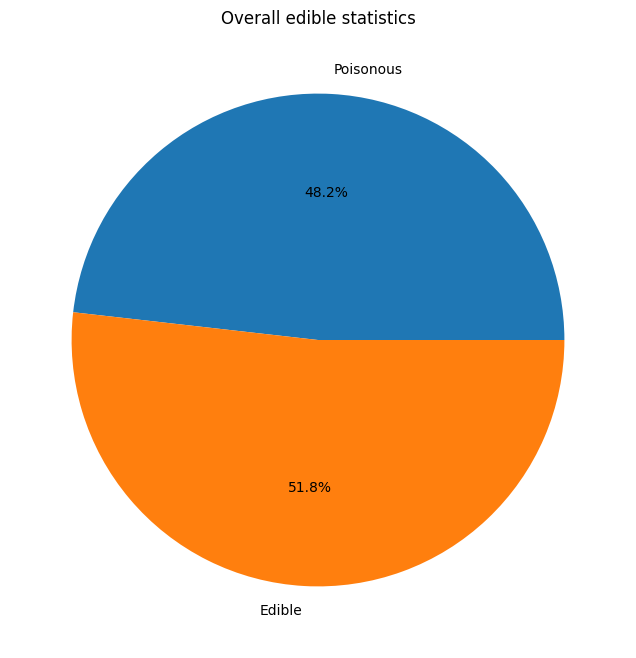

In [238]:
# pie chart showing overall poisonous statistics
fig, ax = plt.subplots(figsize=(8,8))
data['class'].sum()
plt.pie([data['class'].sum(), data.shape[0] - data['class'].sum()], labels=['Poisonous', 'Edible'], autopct='%1.1f%%')
ax.set_title("Overall edible statistics")
plt.savefig("mushroom_plots/edible.png")

      class  count
odor              
a         0    400
c       192    192
f      2160   2160
l         0    400
m        36     36
n       120   3528
p       256    256
s       576    576
y       576    576


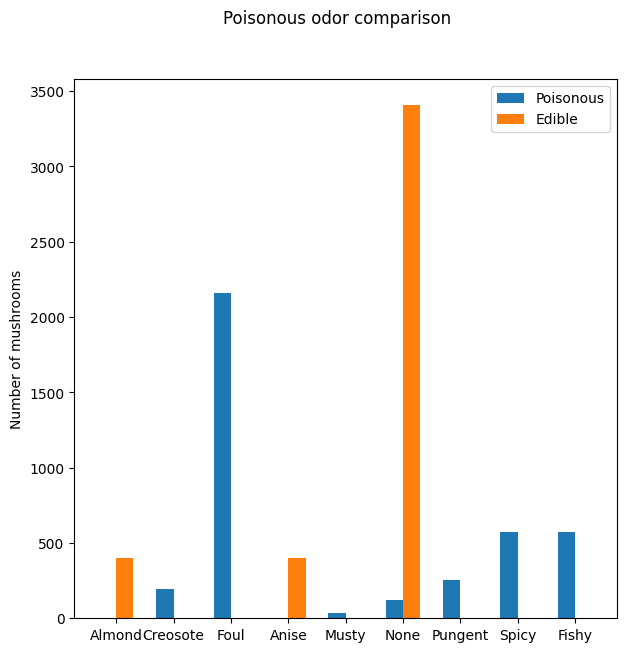

In [239]:
# bar chart showing poisonous vs odor in training data

# find data on which mushrooms are poisonous or edible based on odor
groupby_class = data.groupby(['odor']).sum(numeric_only=True)
print(groupby_class)
class_poison = groupby_class['class']
class_edible = groupby_class['count'] - groupby_class['class']

# create grouped bar chart
fig, ax = plt.subplots(figsize=(7,7))
width = 0.3
x = np.arange(len(class_edible))
poison_bars = ax.bar(x - width/2, class_poison, width, label = "Poisonous")
edible_bars = ax.bar(x + width/2, class_edible, width, label = "Edible")

# aethestics
ax.set_ylabel("Number of mushrooms")
ax.set_xticks(range(len(class_edible)))
ax.set_xticklabels(["Almond","Creosote","Foul","Anise","Musty","None","Pungent","Spicy","Fishy"])
ax.legend()
fig.suptitle("Poisonous odor comparison")
plt.savefig("mushroom_plots/poison_by_odor.png")

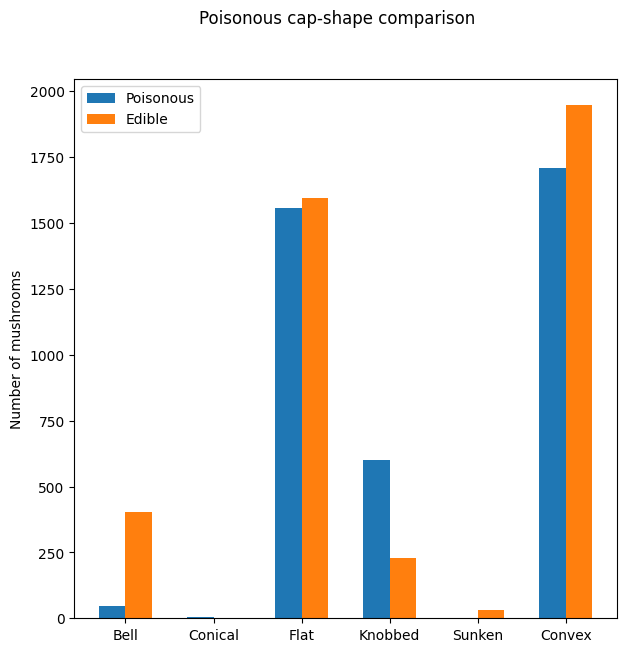

In [240]:
# bar chart showing poisonous vs cap-shape in training data

# find data on which mushrooms are poisonous or edible based on cap-shape
groupby_class = data.groupby(['cap-shape']).sum(numeric_only=True)
class_poison = groupby_class['class']
class_edible = groupby_class['count'] - groupby_class['class']

# create grouped bar chart
fig, ax = plt.subplots(figsize=(7,7))
width = 0.3
x = np.arange(len(class_edible))
poison_bars = ax.bar(x - width/2, class_poison, width, label = "Poisonous")
edible_bars = ax.bar(x + width/2, class_edible, width, label = "Edible")

# aethestics
ax.set_ylabel("Number of mushrooms")
ax.set_xticks(range(len(class_edible)))
ax.set_xticklabels(["Bell","Conical","Flat","Knobbed","Sunken","Convex"])
ax.legend()
fig.suptitle("Poisonous cap-shape comparison")
plt.savefig("mushroom_plots/poison_by_cap-shape.png") 

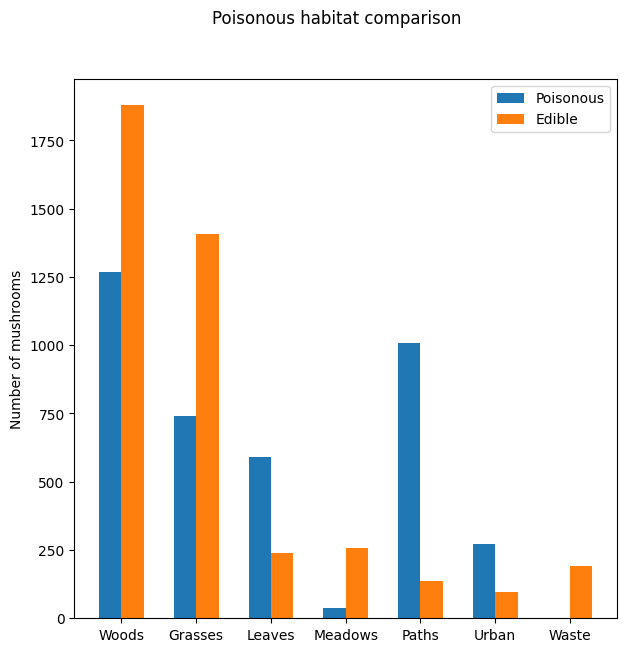

In [241]:
# bar chart showing poisonous vs habitat in training data

# find data on which mushrooms are poisonous or edible based on habitat
groupby_class = data.groupby(['habitat']).sum(numeric_only=True)
class_poison = groupby_class['class']
class_edible = groupby_class['count'] - groupby_class['class']

# create grouped bar chart
fig, ax = plt.subplots(figsize=(7,7))
width = 0.3
x = np.arange(len(class_edible))
poison_bars = ax.bar(x - width/2, class_poison, width, label = "Poisonous")
edible_bars = ax.bar(x + width/2, class_edible, width, label = "Edible")

# aethestics
ax.set_ylabel("Number of mushrooms")
ax.set_xticks(range(len(class_edible)))
ax.set_xticklabels(["Woods","Grasses","Leaves","Meadows","Paths","Urban","Waste"])
ax.legend()
fig.suptitle("Poisonous habitat comparison")
plt.savefig("mushroom_plots/poison_by_habitat.png") 

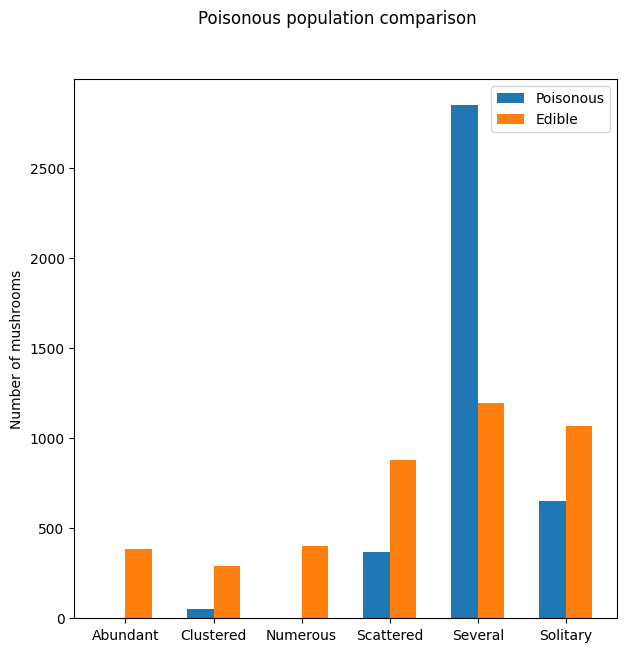

In [242]:
# bar chart showing poisonous vs cap-shape in training data

# find data on which mushrooms are poisonous or edible based on cap-shape
groupby_class = data.groupby(['population']).sum(numeric_only=True)
class_poison = groupby_class['class']
class_edible = groupby_class['count'] - groupby_class['class']

# create grouped bar chart
fig, ax = plt.subplots(figsize=(7,7))
width = 0.3
x = np.arange(len(class_edible))
poison_bars = ax.bar(x - width/2, class_poison, width, label = "Poisonous")
edible_bars = ax.bar(x + width/2, class_edible, width, label = "Edible")

# aethestics
ax.set_ylabel("Number of mushrooms")
ax.set_xticks(range(len(class_edible)))
ax.set_xticklabels(["Abundant","Clustered","Numerous","Scattered","Several","Solitary"])
ax.legend()
fig.suptitle("Poisonous population comparison")
plt.savefig("mushroom_plots/poison_by_population.png") 

In [243]:
# use one hot encoding for data set
one_hot_data = pd.get_dummies(data, columns=data.columns[2:], dtype=int)
one_hot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 119 entries, class to habitat_w
dtypes: int64(119)
memory usage: 7.4 MB


In [244]:
# data splitting
data_to_use = one_hot_data.iloc[:,2:]
data_to_target = one_hot_data.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.25, random_state=43) 

# create statistics dataframe to store accuracy and runtime etc.
acc_db = pd.DataFrame(columns=['Accuracy', 'Run Time (s)'])



In [245]:
# Logistic regression model
start = time.time()
log_reg = LogisticRegression()
# train the model
log_reg.fit(x_train, y_train)
# test model on test data
y_pred_log = log_reg.predict(x_test)
# measure runtime of model
run_time = time.time() - start

db = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_log})

acc_db.loc['Logistic regression'] = [metrics.accuracy_score(y_test,y_pred_log), run_time]

# save the model
with open('log.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

acc_db

,Accuracy,Run Time (s)
Logistic regression,1.0,0.084321


In [246]:
# Gaussian naive bayes model

start = time.time()
gnb = GaussianNB()
# train the model
gnb.fit(x_train,y_train)
# test model on test data
y_pred_gnb = gnb.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction to dataframe
df_gnb = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_gnb})

acc_db.loc['Gaussian naive Bayes'] = [metrics.accuracy_score(y_test, y_pred_gnb), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,1.000000,0.084321
Gaussian naive Bayes,0.965534,0.038689


In [247]:
# find best k for knn model
bestacc = 0
for k in range(30):
    knn_model = KNeighborsClassifier(n_neighbors=k+1)
    knn_model.fit(x_train, y_train)
    y_pred_knn = knn_model.predict(x_test)
    if metrics.accuracy_score(y_test, y_pred_knn) > bestacc:
        bestk = k+1
        bestacc = metrics.accuracy_score(y_test, y_pred_knn)

# kNN model best number of neighbours

start = time.time()
knn_model = KNeighborsClassifier(n_neighbors=bestk)
# train the model
knn_model.fit(x_train, y_train)
# test model on test data
y_pred_knn = knn_model.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction to dataframe
df_knn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_knn})

acc_db.loc['k Neighbours k='+str(bestk)] = [metrics.accuracy_score(y_test, y_pred_knn), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,1.000000,0.084321
Gaussian naive Bayes,0.965534,0.038689
k Neighbours k=1,1.000000,0.296112


In [248]:
# support vector with variable kernel - options: {‘linear’, 'poly', ‘rbf’, ‘sigmoid’}
start = time.time()
kernel = 'linear'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'poly'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'rbf'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'sigmoid'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

acc_db


,Accuracy,Run Time (s)
Logistic regression,1.000000,0.084321
Gaussian naive Bayes,0.965534,0.038689
k Neighbours k=1,1.000000,0.296112
Support Vector kernel=linear,1.000000,0.252467
Support Vector kernel=poly,1.000000,0.984560
Support Vector kernel=rbf,1.000000,0.863039
Support Vector kernel=sigmoid,0.966519,0.464256


In [249]:
# decision tree classifier models with variable depth and criterion
start = time.time()
decisionTree_model_gini = DecisionTreeClassifier(random_state=4000)
# train the model
decisionTree_model_gini.fit(x_train,y_train)
# test model on test data
y_pred_gini = decisionTree_model_gini.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree'] = [metrics.accuracy_score(y_test, y_pred_gini), run_time]

start = time.time()
decisionTree_model_entropy = DecisionTreeClassifier(criterion="entropy", random_state=4000)
# train the model
decisionTree_model_entropy.fit(x_train,y_train)
# test model on test data
y_pred_entropy = decisionTree_model_entropy.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree entropy'] = [metrics.accuracy_score(y_test, y_pred_entropy), run_time]

start = time.time()
decisionTree_model_depth3 = DecisionTreeClassifier(max_depth=3)
# train the model
decisionTree_model_depth3.fit(x_train,y_train)
# test model on test data
y_pred_depth3 = decisionTree_model_depth3.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree depth=3'] = [metrics.accuracy_score(y_test, y_pred_depth3), run_time]

acc_db


,Accuracy,Run Time (s)
Logistic regression,1.000000,0.084321
Gaussian naive Bayes,0.965534,0.038689
k Neighbours k=1,1.000000,0.296112
Support Vector kernel=linear,1.000000,0.252467
Support Vector kernel=poly,1.000000,0.984560
Support Vector kernel=rbf,1.000000,0.863039
Support Vector kernel=sigmoid,0.966519,0.464256
Decision tree,1.000000,0.030258
Decision tree entropy,1.000000,0.023312
Decision tree depth=3,0.985721,0.022321


In [250]:
# random forest classifier with variable n
start = time.time()
n = 100
rfc = RandomForestClassifier(n_estimators=n)
# train the model
rfc.fit(x_train,y_train)
# test model on test data
y_pred_rfc = rfc.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Random Forest n='+str(n)] = [metrics.accuracy_score(y_test, y_pred_depth3), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,1.000000,0.084321
Gaussian naive Bayes,0.965534,0.038689
k Neighbours k=1,1.000000,0.296112
Support Vector kernel=linear,1.000000,0.252467
Support Vector kernel=poly,1.000000,0.984560
Support Vector kernel=rbf,1.000000,0.863039
Support Vector kernel=sigmoid,0.966519,0.464256
Decision tree,1.000000,0.030258
Decision tree entropy,1.000000,0.023312
Decision tree depth=3,0.985721,0.022321


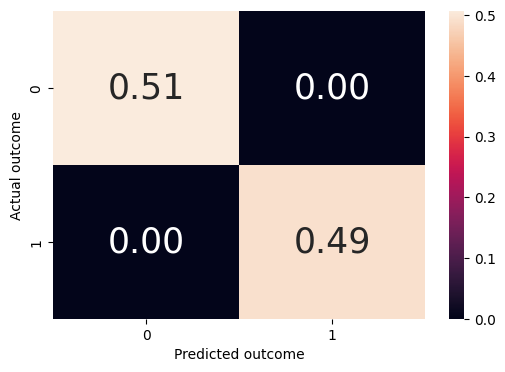

In [251]:
# confusion matrix for best logistic regression model
conf_mat_knn = confusion_matrix(y_test, y_pred_log)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat_knn/np.sum(conf_mat_knn), annot=True, fmt='.2f', annot_kws = {'size':25})
ax.set_ylabel("Actual outcome")
ax.set_xlabel("Predicted outcome")
plt.savefig("mushroom_plots/confusion_matrix_log.png")

In [252]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1030
           1       1.00      1.00      1.00      1001

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



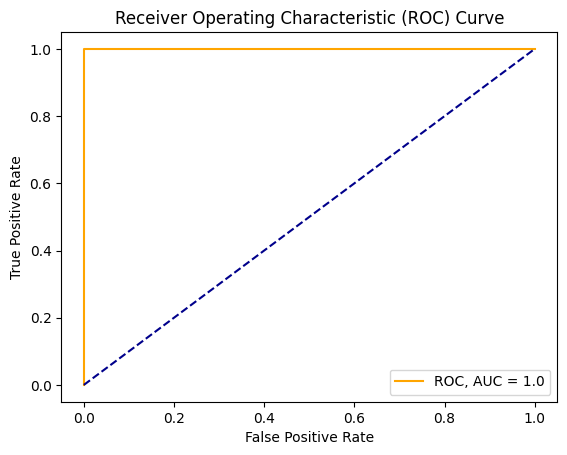

In [253]:
fpr, tpr = roc_curve(y_test, y_pred_knn)[0:2]
auc = roc_auc_score(y_test, y_pred_knn)

plt.plot(fpr, tpr, color='orange', label=f'ROC, AUC = {auc}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

Epoch 1/10


c:\Users\aferg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9240 - loss: 0.3041 - val_accuracy: 0.9980 - val_loss: 0.0058
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9999 - loss: 0.0046 - val_accuracy: 0.9993 - val_loss: 0.0023
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.2177e-04
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.8215e-04 - val_accuracy: 1.0000 - val_loss: 1.7781e-04
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 2.4500e-04 - val_accuracy: 1.0000 - val_loss: 1.0499e-04
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.3094e-04 - val_accuracy: 1.0000 - val_loss: 7.9218e-05
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.5151e-04 - val_accuracy: 1.0000 - val_loss: 5.2833e-05
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 

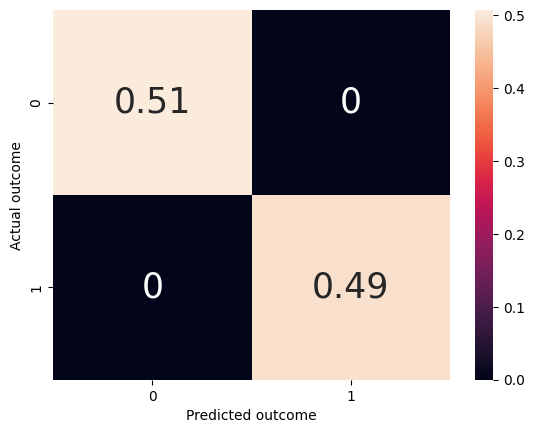

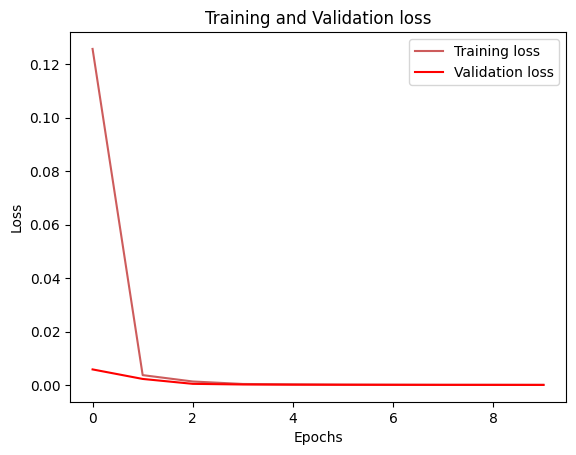

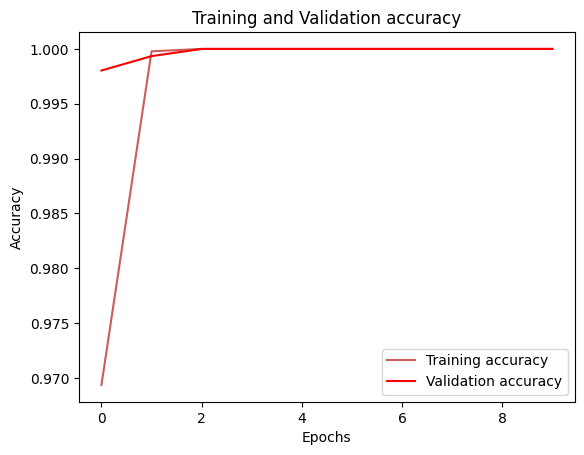

In [254]:
## neural network
start = time.time()
model = Sequential()

##set up the layers
## input layer
model.add(Dense(units= 117, kernel_initializer= 'uniform', activation = 'leaky_relu', input_dim = 117)) 
## hidden layer 1 
model.add(Dense(units= 30, kernel_initializer= 'uniform', activation = 'leaky_relu')) 
##regularization 1
#model.add(Dropout(0.4)) # setting 40% of the data to zero to avoid overfitting
## hidden layer 2
#model.add(Dense(units= 20, kernel_initializer= 'uniform', activation = 'leaky_relu')) 
## regularization 2
model.add(Dropout(0.2)) # another regularisation to avoid overfitting
## output layer
model.add(Dense(units= 1, kernel_initializer= 'uniform', activation = 'sigmoid')) 

## compiling the ANN
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])

## train the model with early stopping after enough consecutive epochs without improvement in loss
callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(x_train, y_train, batch_size = 15, epochs = 10, validation_split=0.25, callbacks=[callback])

## test the model
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
run_time = time.time() - start

print(f"Total run time is: {run_time}")
history_df = pd.DataFrame(history.history)

# confusion matrix for neural network
fig1 = plt.subplots()
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':25})
plt.ylabel("Actual outcome")
plt.xlabel("Predicted outcome")
plt.savefig("mushroom_plots/confusion_matrix_ann.png")

print(classification_report(y_test, y_pred))

# plot of training and validation loss
fig2 = plt.subplots()
plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.savefig("mushroom_plots/loss_chart.png")

# Training and validation accuracy plot
fig3 = plt.subplots()
plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("mushroom_plots/accuracy_chart.png")